In [ ]:
!apt-get update
!apt-get install openjdk-11-jdk -y
!pip install pyspark

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,721 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,994 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Nasa Web Logs Analysis") \
    .getOrCreate()

# Use spark.version (lowercase v) to access the Spark version
print(f"Spark Version : {spark.version}")

Spark Version : 3.5.1


In [ ]:
from google.colab import files
uploaded = files.upload()

log_file_path = list(uploaded.keys())[0]

raw_data = spark.read.text(f"/content/{log_file_path}")
raw_data.show(truncate=False)

In [ ]:
from pyspark.sql.functions import regexp_extract

# Regular expressions for parsing
host_pattern = r'^(\S+)'  # Extracts host
timestamp_pattern = r'\[(.*?)\]'  # Extracts timestamp
method_endpoint_pattern = r'"(GET|POST|HEAD|PUT|DELETE)\s(\S+)\s'  # Extracts HTTP method and endpoint
status_pattern = r'(\d{3})'  # Extracts status code
content_size_pattern = r'(\d+)$'  # Extracts content size

# Parse data into structured columns
logs_df = raw_data.withColumn("host", regexp_extract("value", host_pattern, 1)) \
    .withColumn("timestamp", regexp_extract("value", timestamp_pattern, 1)) \
    .withColumn("endpoint", regexp_extract("value", method_endpoint_pattern, 2)) \
    .withColumn("status", regexp_extract("value", status_pattern, 1).cast("int")) \
    .withColumn("content_size", regexp_extract("value", content_size_pattern, 1).cast("int"))

logs_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------+------------+
|               value|                host|           timestamp|            endpoint|status|content_size|
+--------------------+--------------------+--------------------+--------------------+------+------------+
|199.72.81.55 - - ...|        199.72.81.55|01/Jul/1995:00:00...|    /history/apollo/|   199|        6245|
|unicomp6.unicomp....|unicomp6.unicomp.net|01/Jul/1995:00:00...| /shuttle/countdown/|   199|        3985|
|199.120.110.21 - ...|      199.120.110.21|01/Jul/1995:00:00...|/shuttle/missions...|   199|        4085|
|burger.letters.co...|  burger.letters.com|01/Jul/1995:00:00...|/shuttle/countdow...|   199|           0|
|199.120.110.21 - ...|      199.120.110.21|01/Jul/1995:00:00...|/shuttle/missions...|   199|        4179|
+--------------------+--------------------+--------------------+--------------------+------+------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import regexp_extract
#Regular expressions for parsing
host_pattern=r'^(\S+)' # Extracts host
timestamp_pattern = r'\[(.*?)\]' # Extracts timestamp
method_endpoint_pattern = r'\" (GET|POST|HEAD|PUT|DELETE)\s(\S+)\s' # Extracts HTTP method and endpoint
status_pattern= r'(\d{3})' # Extracts status code
content_size_pattern = r'(\d+)$' # Extracts content size
#Parse data into structured columns
logs_df = raw_data.withColumn("host", regexp_extract("value", host_pattern, 1))\
.withColumn("timestamp", regexp_extract("value", timestamp_pattern, 1)) \
.withColumn("endpoint", regexp_extract("value", method_endpoint_pattern, 2)) \
.withColumn("status", regexp_extract("value", status_pattern, 1).cast("int")) \
.withColumn("content_size", regexp_extract("value", content_size_pattern, 1).cast("int"))
logs_df.show(5)


+--------------------+--------------------+--------------------+--------+------+------------+
|               value|                host|           timestamp|endpoint|status|content_size|
+--------------------+--------------------+--------------------+--------+------+------------+
|199.72.81.55 - - ...|        199.72.81.55|01/Jul/1995:00:00...|        |   199|        6245|
|unicomp6.unicomp....|unicomp6.unicomp.net|01/Jul/1995:00:00...|        |   199|        3985|
|199.120.110.21 - ...|      199.120.110.21|01/Jul/1995:00:00...|        |   199|        4085|
|burger.letters.co...|  burger.letters.com|01/Jul/1995:00:00...|        |   199|           0|
|199.120.110.21 - ...|      199.120.110.21|01/Jul/1995:00:00...|        |   199|        4179|
+--------------------+--------------------+--------------------+--------+------+------------+
only showing top 5 rows



In [ ]:
#a
logs_df.selectExpr(
    "AVG(content_size) as avg_content_size",
    "MAX(content_size) as max_content_size",
    "MIN(content_size) as min_content_size"
).show()

+------------------+----------------+----------------+
|  avg_content_size|max_content_size|min_content_size|
+------------------+----------------+----------------+
|20671.058516934936|         6823936|               0|
+------------------+----------------+----------------+



In [ ]:
#b
logs_df.groupBy("status").count().orderBy("status").show()

+------+-----+
|status|count|
+------+-----+
|  NULL|    1|
|     0| 2065|
|     1| 3863|
|     2| 3874|
|     3| 2795|
|     4| 2905|
|     5| 3074|
|     6| 2996|
|     7| 2636|
|     8| 2155|
|     9| 1785|
|    10| 2976|
|    11| 2280|
|    12| 2422|
|    13| 2684|
|    14| 2235|
|    15| 2892|
|    16| 2306|
|    17| 2190|
|    18| 1738|
+------+-----+
only showing top 20 rows



In [ ]:
#C
from pyspark.sql.functions import desc
logs_df.groupBy("host").count().orderBy(desc("count")).limit(10).show()

+--------------------+-----+
|                host|count|
+--------------------+-----+
|piweba3y.prodigy.com|17572|
|piweba4y.prodigy.com|11591|
|piweba1y.prodigy.com| 9868|
|  alyssa.prodigy.com| 7852|
| siltb10.orl.mmc.com| 7573|
|piweba2y.prodigy.com| 5922|
|  edams.ksc.nasa.gov| 5434|
|        163.206.89.4| 4906|
|         news.ti.com| 4863|
|disarray.demon.co.uk| 4353|
+--------------------+-----+



In [ ]:
#d
logs_df.groupBy("endpoint").count().orderBy(desc("count")).limit(20).show()

+--------+-------+
|endpoint|  count|
+--------+-------+
|        |1891715|
+--------+-------+



In [ ]:
#e
logs_df.filter("status >= 400").groupBy("endpoint").count().orderBy("count", ascending=False).limit(10).show()

+--------+-----+
|endpoint|count|
+--------+-----+
|        |30652|
+--------+-----+



In [ ]:
#f
unique_hosts = logs_df.select("host").distinct().count()
print(f"Unique hosts: {unique_hosts}")

Unique hosts: 81983


In [ ]:
#B
total_requests = logs_df.count()
avg_requests_per_host = total_requests / unique_hosts
print (f"Average requests per host: {avg_requests_per_host}")

Average requests per host: 23.074478855372455


In [ ]:
#h
logs_df.filter("status == 404").groupBy("endpoint").count().orderBy(desc("count")).limit(20).show()

+--------------------+-----+
|            endpoint|count|
+--------------------+-----+
|/images/ksclogo-m...|    5|
|/images/USA-logos...|    5|
|/images/NASA-logo...|    5|
|/images/MOSAIC-lo...|    5|
|/images/WORLD-log...|    5|
|                   /|    3|
|/shuttle/countdow...|    3|
|/history/apollo/i...|    3|
|/images/KSC-logos...|    3|
| /shuttle/countdown/|    3|
|           /ksc.html|    2|
|/shuttle/countdow...|    2|
|/history/apollo/i...|    2|
|/shuttle/missions...|    2|
|/history/apollo/i...|    1|
|/facilities/lc39a...|    1|
|/shuttle/countdow...|    1|
|/history/apollo/a...|    1|
|/images/whatsnew.gif|    1|
|/images/kscmap-ti...|    1|
+--------------------+-----+



In [ ]:
#i
logs_df.filter("status==404").groupBy("host").count().orderBy(desc("count")).limit(20).show()

+--------------------+-----+
|                host|count|
+--------------------+-----+
|gespie4044.erin.u...|   35|
| ppp404.st.rim.or.jp|   12|
|i404ae1a.cfa.ilst...|   11|
| slip4040.sirius.com|    8|
|sunm4048aq.sph.um...|    7|
|ppp404.po.iijnet....|    7|
| slip4041.sirius.com|    6|
|meb404a-1.anesth....|    5|
|  grail404.nando.net|    1|
| slip4044.sirius.com|    1|
+--------------------+-----+



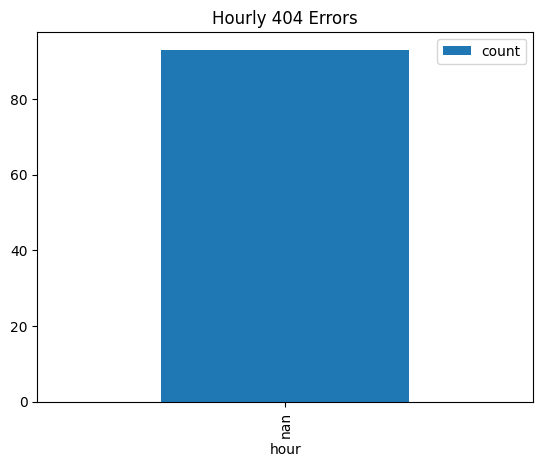

In [ ]:
#1
from pyspark.sql.functions import hour
import matplotlib.pyplot as plt
hourly_404 = logs_df.filter("status==404").withColumn ("hour", hour("timestamp"))\
                  .groupBy("hour").count().toPandas()

hourly_404.plot(x="hour", y="count", kind="bar", title="Hourly 404 Errors")
plt.show()

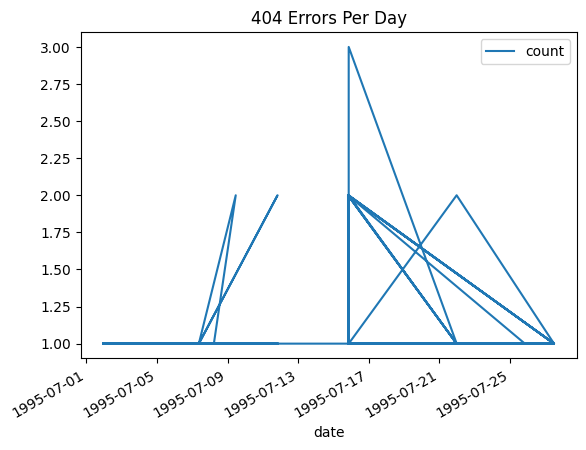

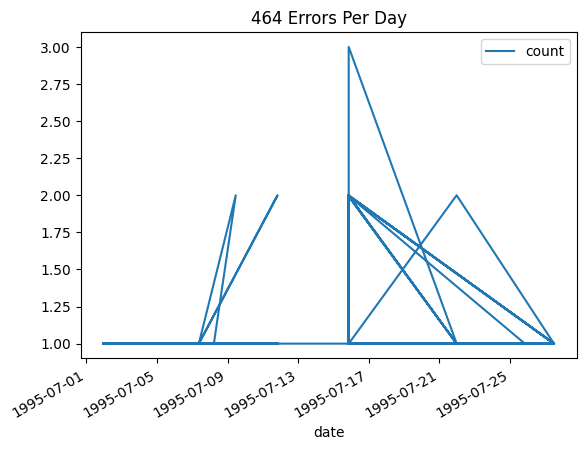

In [ ]:
#j
from pyspark.sql.functions import to_timestamp
# Set legacy parser policy if needed
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
# Correct timestamp parsing
correct_format = "dd/MMM/yyyy:HH:mm:ss Z"
daily_404 = logs_df.filter("status == 404") \
.withColumn("date", to_timestamp("timestamp", correct_format)) \
.groupBy("date").count().toPandas()
import matplotlib.pyplot as plt
# Plot the result
daily_404.plot(x="date", y="count", kind="line", title="404 Errors Per Day")
plt.show()
import matplotlib.pyplot as plt
daily_404.plot(x="date", y="count", kind="line", title="464 Errors Per Day")
plt.show()

In [ ]:
from pyspark.sql.functions import to_date, desc# Import to date and desc
logs_df.filter("status == 404") \
.withColumn("date", to_date("timestamp", "dd/MMM/yyyy")) \
.groupBy("date").count() \
.orderBy(desc("count")) \
.limit(3) \
.show()

+----------+-----+
|      date|count|
+----------+-----+
|1995-07-15|   36|
|1995-07-21|   11|
|1995-07-27|    8|
+----------+-----+

